In [76]:
from dataloader import DataLoader
import warnings
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
warnings.filterwarnings("ignore")

In [77]:
loader = DataLoader(hs_code=282520)

_initialize_data took 22.2987 seconds


In [78]:
polar_df = loader.get_data()
df = polar_df.to_pandas()

In [79]:
country_name_mapping = {
    "USA": "United States of America",
    "Türkiye": "Turkey",
    'China, Hong Kong SAR': 'China',
    'Other Asia, nes': 'China',
    'Dem. Rep. of the Congo': 'Democratic Republic of the Congo',
    'Serbia':"Republic of Serbia",
    'Malta':"Italy",
    'Russian Federation':"Russia",
    'Eswatini':"eSwatini",
    'Rep. of Korea':"South Korea",
    'Czech Republic':'Czechia',
    'United States':"United States of America",
    'Bolivia (Plurinational State of)':"Bolivia",
    'Rep. of Moldova':"Moldova",
    'United Rep. of Tanzania': "United Republic of Tanzania",
    "Viet Nam":"Vietnam"
}

def normalize_country_names(data, column_name):
    return data[column_name].replace(country_name_mapping)

In [80]:
def preprocess(year):
    shapefile_path = os.path.join("../data/dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)

    export_data = df[df['t'] == year].groupby('export_country')['v'].sum().reset_index()
    import_data = df[df['t'] == year].groupby('import_country')['v'].sum().reset_index()

    export_data['export_country'] = normalize_country_names(export_data, 'export_country')
    import_data['import_country'] = normalize_country_names(import_data, 'import_country')

    export_data = export_data.groupby('export_country')['v'].sum().reset_index()
    import_data = import_data.groupby('import_country')['v'].sum().reset_index()

    unmatched_exports = set(export_data['export_country']) - set(world['ADMIN'])
    unmatched_imports = set(import_data['import_country']) - set(world['ADMIN'])

    if unmatched_exports or unmatched_imports:
        print(
            f"Unmatched countries found:\n"
            f"Exports - {unmatched_exports}\n"
            f"Imports - {unmatched_imports}\n"
        )

    world_export = world.merge(export_data, left_on="ADMIN", right_on="export_country", how="left")
    world_import = world.merge(import_data, left_on="ADMIN", right_on="import_country", how="left")

    return world_export, world_import

In [81]:
gray_blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_blue",
    ["gray", "blue"]
)

gray_red_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_red",
    ["gray", "red"]
)

Unmatched countries found:
Exports - {'Singapore'}
Imports - {'Singapore'}



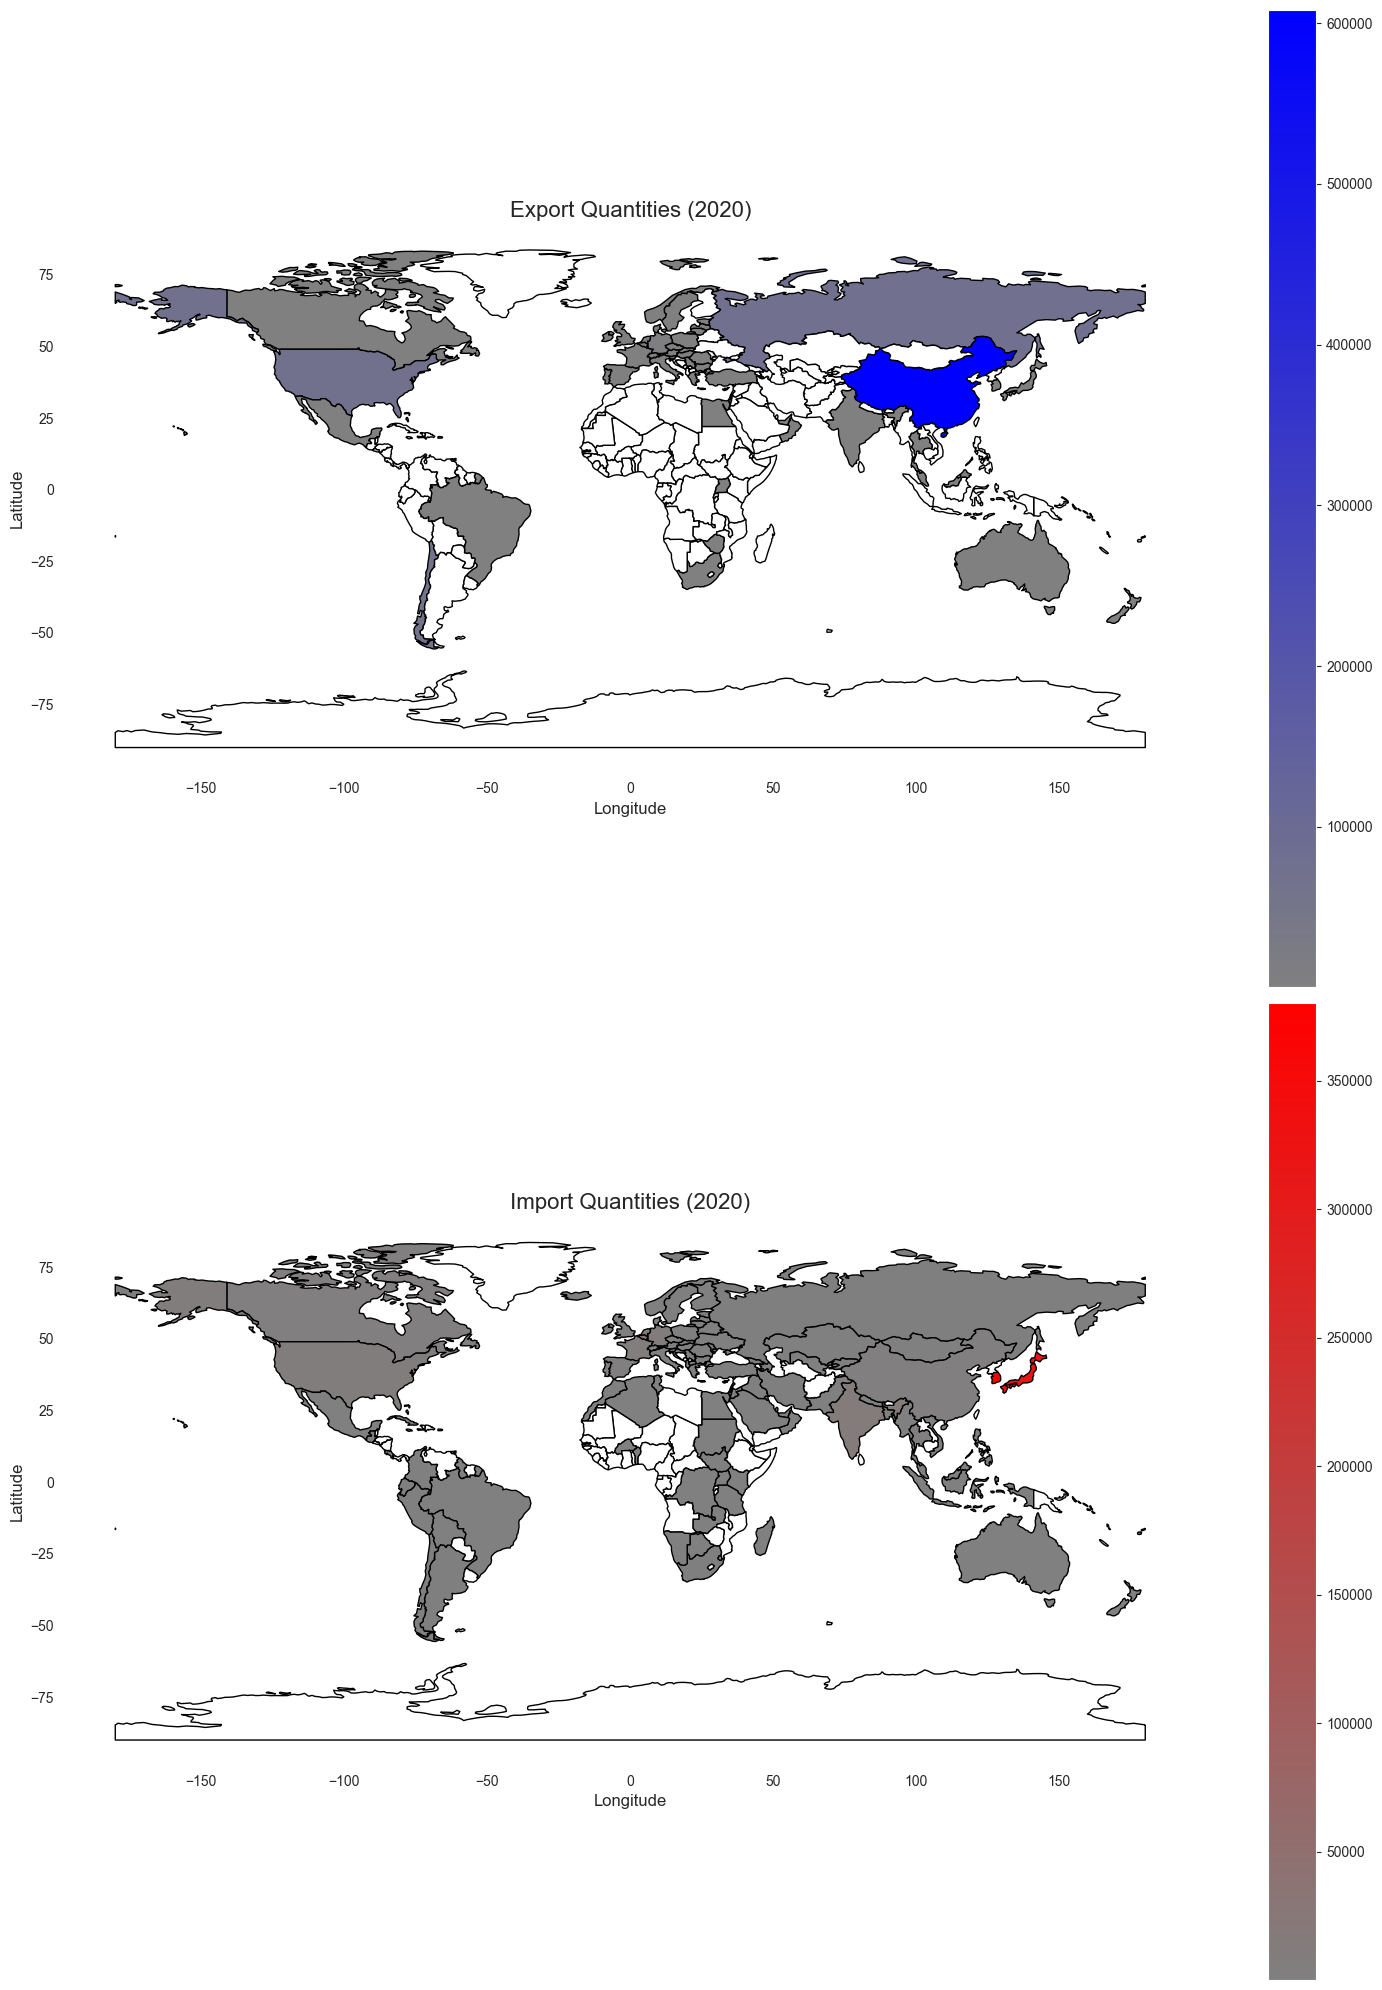

In [82]:
def plot_map(year):
    world_export, world_import = preprocess(year)
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
    fig.patch.set_facecolor('white')
    for a in ax:
        a.set_facecolor('white')
    world_export.plot(
        column="v",
        cmap=gray_blue_cmap,
        legend=True,
        ax=ax[0],
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax[0].set_title(f"Export Quantities ({year})", fontsize=16)
    ax[0].set_xlabel("Longitude", fontsize=12)
    ax[0].set_ylabel("Latitude", fontsize=12)

    world_import.plot(
        column="v",
        cmap=gray_red_cmap,
        legend=True,
        ax=ax[1],
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax[1].set_title(f"Import Quantities ({year})", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=12)
    ax[1].set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join("../graphics", "net_export_map_vertical.png"), dpi=300, facecolor='white')
    plt.show()

plot_map(2020)


Unmatched countries found:
Exports - {'Singapore'}
Imports - {'Singapore'}



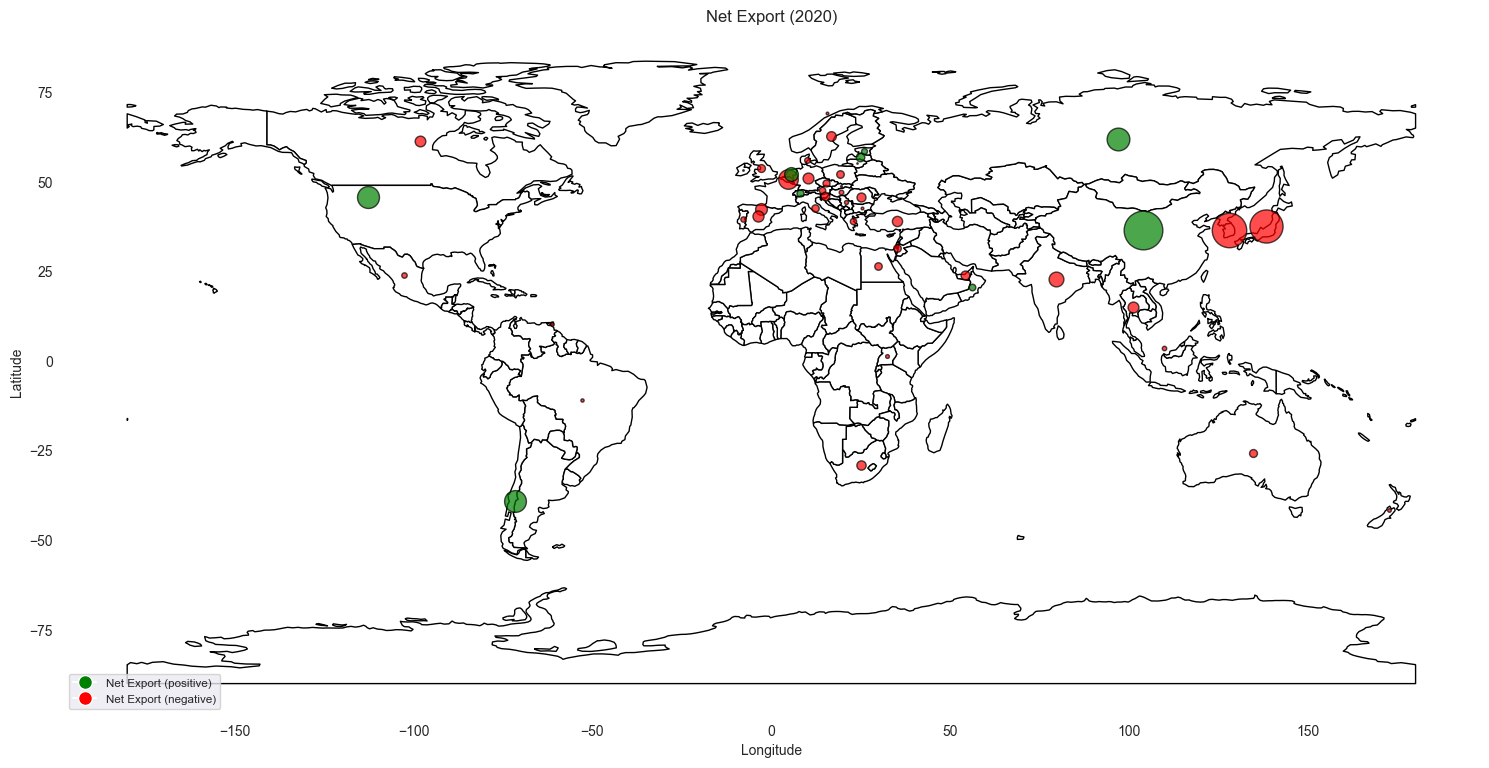

In [83]:
def plot_map_2(year: int):
    shapefile_path = os.path.join("../data/dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)
    world_export, world_import = preprocess(year)

    net_export = (
        world_export.set_index("export_country")["v"]
        - world_import.set_index("import_country")["v"]
    ).reset_index()
    net_export.columns = ["country", "net_export"]

    world_net = world.merge(net_export, left_on="ADMIN", right_on="country", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    world.plot(ax=ax, color="white", edgecolor="black")
    ax.set_facecolor('none')

    for _, row in world_net.iterrows():
        if pd.notnull(row["net_export"]) and row["net_export"] != 0:
            size = np.sqrt(abs(row["net_export"]))
            color = "green" if row["net_export"] > 0 else "red"
            ax.scatter(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                s=size,
                color=color,
                alpha=0.7,
                edgecolor="black"
            )

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Net Export (positive)"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Net Export (negative)"),
    ]
    ax.legend(handles=handles, loc="lower left", fontsize="small")

    ax.set_title(f"Net Export ({year})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.savefig(os.path.join("../graphics", "net_export_map_2.png"), dpi=300, transparent=True)
    plt.show()

plot_map_2(2020)


Unmatched countries found:
Exports - {'Singapore'}
Imports - {'Singapore'}



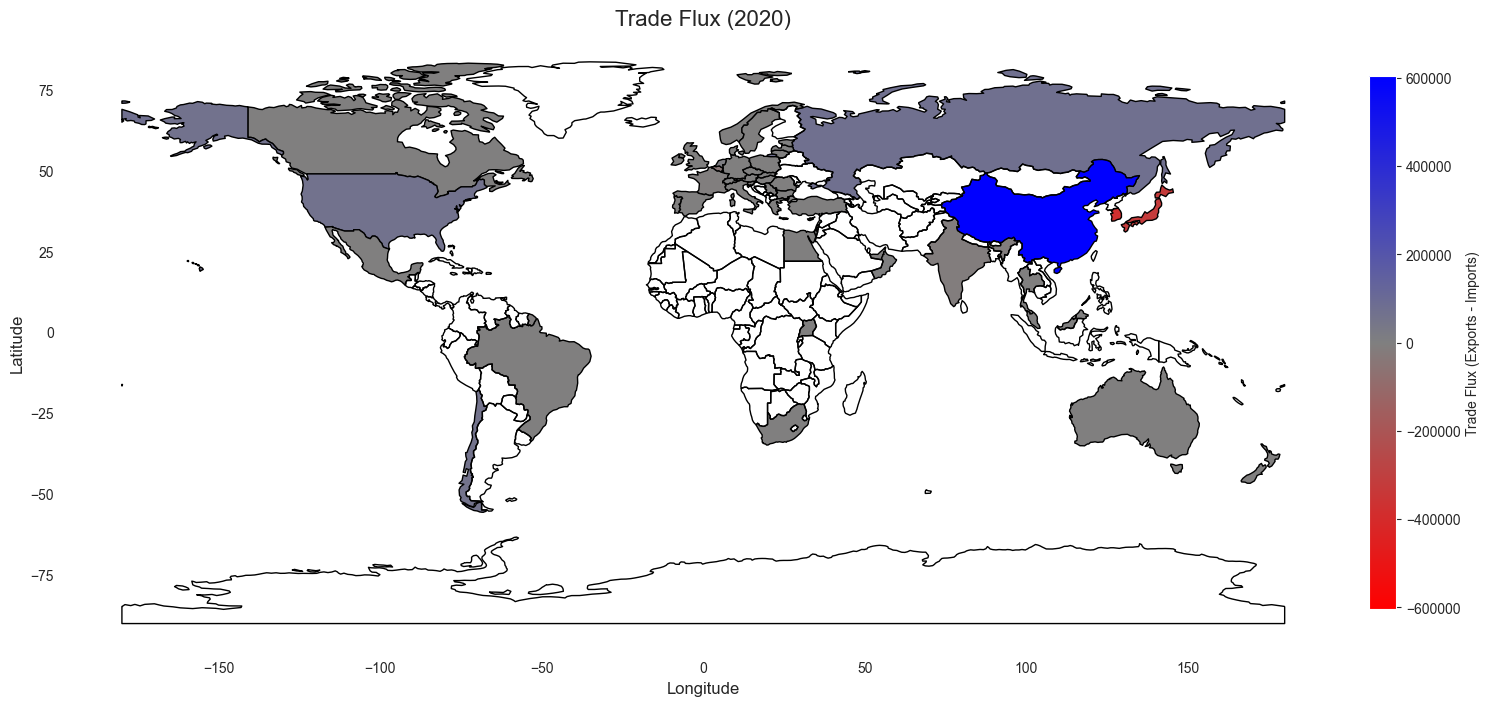

In [84]:
def plot_flux(year):
    world_export, world_import = preprocess(year)

    world_flux = world_export[["ADMIN", "geometry", "v"]].merge(
        world_import[["ADMIN", "v"]], on="ADMIN", suffixes=("_exp", "_imp")
    )
    world_flux["flux"] = world_flux["v_exp"] - world_flux["v_imp"]

    vmax = world_flux["flux"].abs().max()

    flux_cmap = mcolors.LinearSegmentedColormap.from_list("flux_cmap", ["red", "gray", "blue"])
    norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.patch.set_alpha(0)
    ax.set_facecolor((0, 0, 0, 0))

    world_flux.plot(
        column="flux",
        cmap=flux_cmap,
        norm=norm,
        legend=False,
        ax=ax,
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=flux_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Trade Flux (Exports - Imports)")

    ax.set_title(f"Trade Flux ({year})", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(
        os.path.join("../graphics", "trade_flux_map.png"),
        dpi=300,
        transparent=True  # Save with a transparent background
    )
    plt.show()

plot_flux(2020)


Unmatched countries found:
Exports - {'Singapore'}
Imports - {'Singapore'}



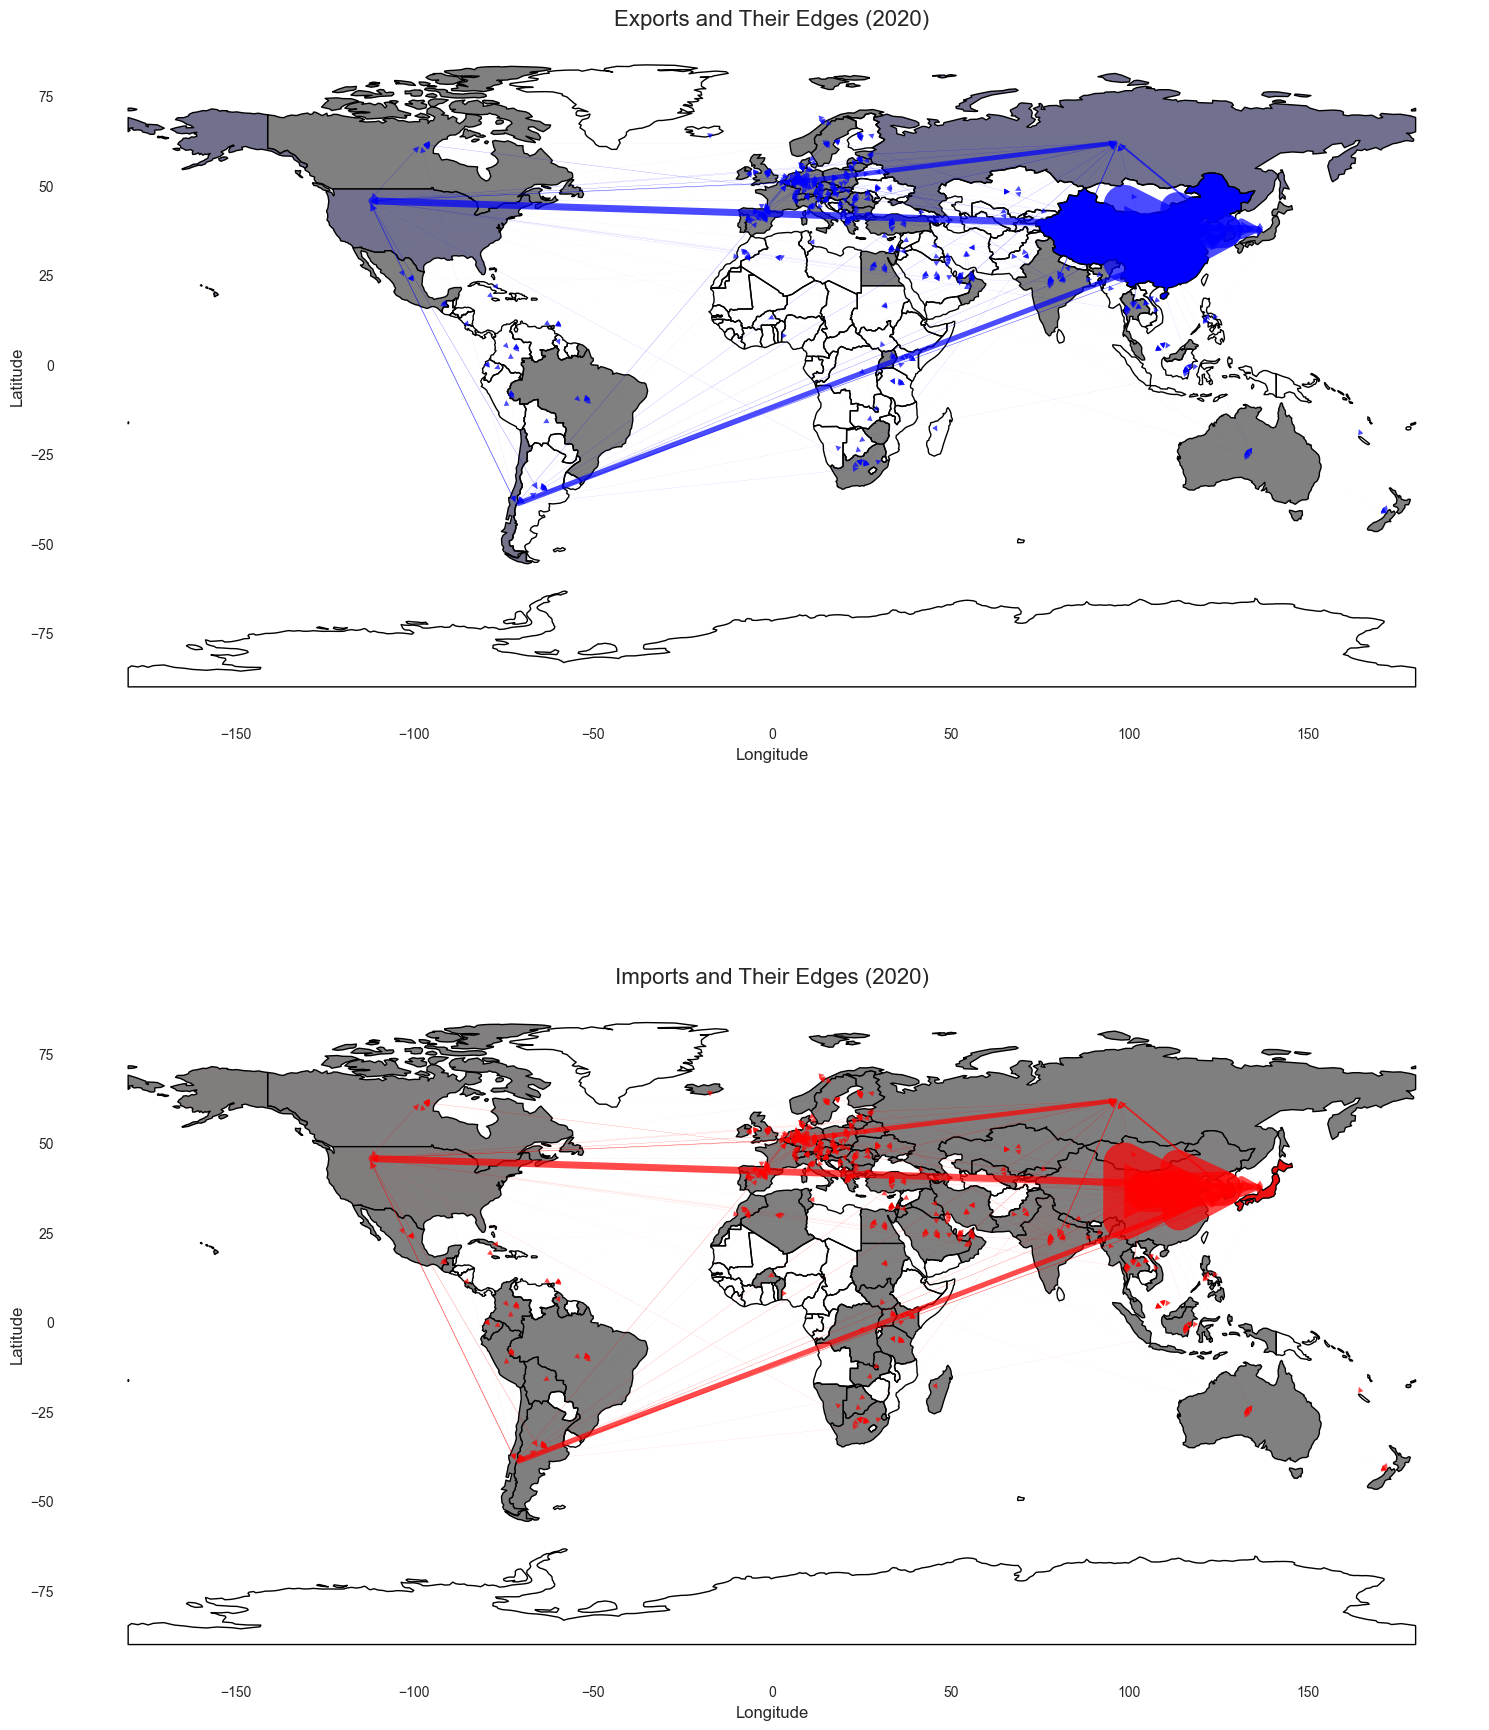

In [85]:
def plot_edges(ax, df_edges, coords, color, max_val):
    for _, row in df_edges.iterrows():
        if row["v"] > 0:
            start = coords.get(row["export_country"])
            end = coords.get(row["import_country"])
            if start is not None and end is not None:
                lw = (row["v"] / max_val) * 30
                arrow = FancyArrowPatch(
                    (start.x, start.y), (end.x, end.y),
                    color=color,
                    linewidth=lw,
                    arrowstyle="-|>",
                    mutation_scale=10 + lw * 3 if lw > 0 else 0,
                    alpha=0.7
                )
                ax.add_patch(arrow)

def plot_map(year):
    world_export, world_import = preprocess(year)
    world = gpd.read_file(os.path.join("../data/dataset", "110m_cultural", "ne_110m_admin_0_countries.shp"))

    edges_data = df[df['t'] == year].groupby(['export_country', 'import_country'])['v'].sum().reset_index()
    edges_data['export_country'] = normalize_country_names(edges_data, 'export_country')
    edges_data['import_country'] = normalize_country_names(edges_data, 'import_country')

    world_centroids = world.copy()
    world_centroids["centroid"] = world_centroids.geometry.centroid
    coords = {row["ADMIN"]: row["centroid"] for _, row in world_centroids.iterrows()}

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
    fig.patch.set_alpha(0)
    for a in ax:
        a.set_facecolor((0, 0, 0, 0))

    world_export.plot(
        column="v",
        cmap=gray_blue_cmap,
        legend=False,
        ax=ax[0],
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    max_export_val = edges_data["v"].max() if not edges_data.empty else 1
    plot_edges(ax[0], edges_data, coords, "blue", max_export_val)

    ax[0].set_title(f"Exports and Their Edges ({year})", fontsize=16)
    ax[0].set_xlabel("Longitude", fontsize=12)
    ax[0].set_ylabel("Latitude", fontsize=12)

    world_import.plot(
        column="v",
        cmap=gray_red_cmap,
        legend=False,
        ax=ax[1],
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    max_import_val = edges_data["v"].max() if not edges_data.empty else 1
    plot_edges(ax[1], edges_data, coords, "red", max_import_val)

    ax[1].set_title(f"Imports and Their Edges ({year})", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=12)
    ax[1].set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join("../graphics", "trade_edges_map_vertical.png"), dpi=300, transparent=True)
    plt.show()

plot_map(2020)
